# Constant Proportion Portfolio Insurance (CPPI) with Drawdown Constraints

CPPI is a trading strategy that dynamically rebalances between a safe asset and a risky asset. The risky asset could be a portfolio itself. This strategy can also be enhanced to include a drawdown constraint, i.e. the maximum drawdown (peak to trough) is set at a certain level.

In [37]:
import numpy as np
import pandas as pd

## Data

I'll be using a historical monthly returns dataset categorized by industry from the Ken French data library: https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html

I've got the following 4 files:

- 30 industries, equally-weighted returns
- 30 industries, value-weighted returns
- 30 industries, average number of firms
- 30 industries, average size (market cap)

Note: the first two files are the historical returns and 'equally-weighted' and 'value-weighted' describes how these are calculated, since they are industry portfolios. This should not be confused with the type of portfolio we will construct later, which can be value-weighted or equally-weighted.

First, I'll write a few functions to retrieve the right dataset easily.

In [38]:
def get_ind_file(filetype, weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios files
    Variant is a tuple of (weighting, size) where:
        weighting is one of "ew", "vw"
        number of inds is 30 or 49
    """    
    if filetype is "returns":
        name = f"{weighting}_rets" 
        divisor = 100
    elif filetype is "nfirms":
        name = "nfirms"
        divisor = 1
    elif filetype is "size":
        name = "size"
        divisor = 1
    else:
        raise ValueError(f"filetype must be one of: returns, nfirms, size")
    
    ind = pd.read_csv(f"data/ind{n_inds}_m_{name}.csv", header=0, index_col=0, na_values=-99.99)/divisor
    ind.index = pd.to_datetime(ind.index, format="%Y%m").to_period('M')
    ind.columns = ind.columns.str.strip()
    return ind

def get_ind_returns(weighting="vw", n_inds=30):
    """
    Load and format the Ken French Industry Portfolios Monthly Returns
    """
    return get_ind_file("returns", weighting=weighting, n_inds=n_inds)

def get_ind_size(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average size (market cap)
    """
    return get_ind_file("size", n_inds=n_inds)

def get_ind_market_caps(n_inds=30, weights=False):
    """
    Load the industry portfolio data and derive the market caps
    """
    ind_nfirms = get_ind_nfirms(n_inds=n_inds)
    ind_size = get_ind_size(n_inds=n_inds)
    ind_mktcap = ind_nfirms * ind_size
    if weights:
        total_mktcap = ind_mktcap.sum(axis=1)
        ind_capweight = ind_mktcap.divide(total_mktcap, axis="rows")
        return ind_capweight
    #else
    return ind_mktcap

def get_ind_nfirms(n_inds=30):
    """
    Load and format the Ken French 30 Industry Portfolios Average number of Firms
    """
    return get_ind_file("nfirms", n_inds=n_inds)

def get_total_market_index_returns():
    ind_return = get_ind_returns()
    ind_nfirms = get_ind_nfirms()
    ind_size = get_ind_size()
    ind_mktcap = ind_nfirms * ind_size
    tot_mktcap = ind_mktcap.sum(axis='columns')
    ind_capweight = ind_mktcap.divide(tot_mktcap, axis='rows')
    total_market_return = (ind_capweight * ind_return).sum(axis='columns')
    return total_market_return

Setting up the returns datasets to use.

In [39]:
ind_return = get_ind_returns()
tmi_return = get_total_market_index_returns()

## The CPPI Algorithm

This is about dynamically allocating to the risky and safe asset subject to a floor constraint. I'll only look at three industries from the dataset (Steel, Finance, Beer) for the purpose of this analysis to speed up computation time.

For a risk-free rate of return for the safe aset, I'll assume a return of 50 bps.

In [40]:
#Risky asset
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]
#Safe asset
safe_r = pd.DataFrame().reindex_like(risky_r)
#Choose a risk-free rate of return for the safe asset
safe_r[:] = 0.005/12
#Starting account value
start = 1000
#We'll set the floor to 80% of our asset value
floor = 0.8

The steps will be:

- Cushion = Asset value - Floor value

- Compute an allocation to safe and risky assets --> m*cushion, where m is a multiplier (I've chosen 3)

- Recompute the asset value based on the returns

In [41]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value - floor_value)/account_value
    risky_w = m * cushion
    risky_w = np.minimum(risky_w, 1)  # no leverage
    risky_w = np.maximum(risky_w, 0)  # no shorting
    safe_w = 1 - risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # update account value for this time step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    #Save the values to be able to look at the history and plot it
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w

In [42]:
account_history.head()

,Steel,Fin,Beer
2000-01,983.546667,973.646667,986.486667
2000-02,1021.390820,929.607488,921.543450
2000-03,1044.719280,994.727285,922.249517
2000-04,1038.681755,970.070617,935.977322
2000-05,1003.586760,996.078944,984.618866


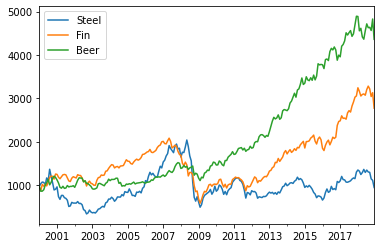

In [43]:
risky_wealth = start *(1+risky_r).cumprod()
risky_wealth.plot()

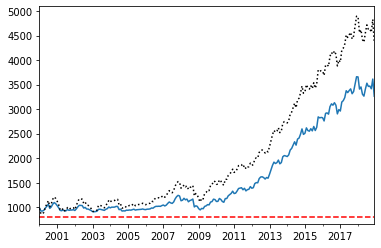

In [44]:
ax = account_history['Beer'].plot()
risky_wealth['Beer'].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

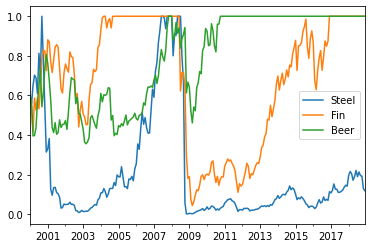

In [45]:
risky_w_history.plot()

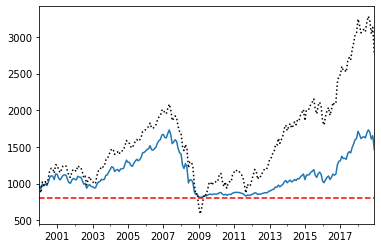

In [46]:
ind='Fin'
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

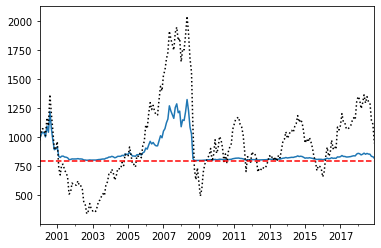

In [47]:
ind='Steel'
ax = account_history[ind].plot()
risky_wealth[ind].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

In [48]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risky Budget (Cushion) History, Risky Weight History 
    """
    #Setup CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = start
    
    if isinstance(risky_r, pd.Series):
        risky_r = pd.DataFrame(risky_r, columns=['R'])
    
    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 #fast way to set all values to a number
    
    #Setup DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak * (1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m * cushion
        risky_w = np.minimum(risky_w, 1)  # no leverage
        risky_w = np.maximum(risky_w, 0)  # no shorting
        safe_w = 1 - risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # Recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        #Save the histories for analysis and plotting
        account_history.iloc[step] = account_value
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
    
    risky_wealth = start*(1+risky_r).cumprod()
    
    backtest_result = {
        'Wealth': account_history,
        'Risky Wealth': risky_wealth,
        'Risk Budget': cushion_history,
        'Risky Allocation': risky_w_history,
        'm': m,
        'start': start,
        'floor': floor,
        'risky_r': risky_r,
        'safe_r': safe_r
    }
    return backtest_result

## Performance Metrics

How do we judge how the portfolios performed? I'll use the following metrics:

- Returns
- Volatility
- Sharpe Ratio
- Drawdown
- Skewness
- Kurtosis
- VaR
- CVaR

I'll now write a few functions to calculate these. Note since I'm using monthly data, I'll write functions for annualizing returns and volatility.

In [49]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns   
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    """
    return r.std()*(periods_per_year**0.5)

def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5

# Using the above functions, a new function for Sharpe Ratio
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized Sharpe Ratio of a set of returns,
    given a risk-free rate and periods per year
    """
    # Convert the annual riskfree rate to per period rate
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    # Find excess return over the risk-free rate
    excess_ret = r - rf_per_period
    # Annualize the excess return using the annualize_rets function above
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    # Annualize the volatility using the annualize_rets function above
    ann_vol = annualize_vol(r, periods_per_year)
    # Return the Sharpe Ratio
    return ann_ex_ret/ann_vol

# Drawdown i.e. maximum peak to trough drop
def drawdown(return_series: pd.Series):
    """
    Takes a time series of asset returns
    Computes and returns a DataFrame that contains:
    the wealth index, previous peaks, and percentage drawdowns
    """
    # Compute a wealth index - the value a dollar invested over time
    wealth_index = 1000*(1+return_series).cumprod()
    # Find the previous peak of the wealth index at any point in time
    previous_peaks = wealth_index.cummax()
    # Find the difference between the wealth index and the previous peak
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({
        'Wealth': wealth_index,
        'Previous Peak': previous_peaks,
        'Drawdown': drawdowns
    })

def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number and the (100-level) percent are above
    """
    #If r is a DataFrame, run the function on each of its columns
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    #When we run it on each of the columns, they are no longer DataFrames so 
    #function won't get called again
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be Series or DataFrame")

from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [50]:
def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [51]:
summary_stats(risky_r)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.002790,0.312368,-0.326334,4.144381,0.150139,0.208117,-0.102567,-0.758017
Fin,0.055166,0.192909,-0.533218,4.995534,0.091224,0.132175,0.126718,-0.718465
Beer,0.080598,0.138925,-0.493545,4.173881,0.063015,0.091442,0.354314,-0.271368


In [52]:
btr = run_cppi(risky_r)
summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.005167,0.174180,-1.995143,17.110190,0.091995,0.130153,-0.196750,-0.655198
Fin,0.040894,0.131678,-0.946504,6.051414,0.065535,0.091621,0.080352,-0.549673
Beer,0.075544,0.115462,-0.669250,4.760879,0.052923,0.074908,0.383772,-0.259582


Max drawdowns were smaller than without CPPI - so we successfully reduced downside risk.
On the other hand, the returns with CPPI were a bit smaller, as we expected.

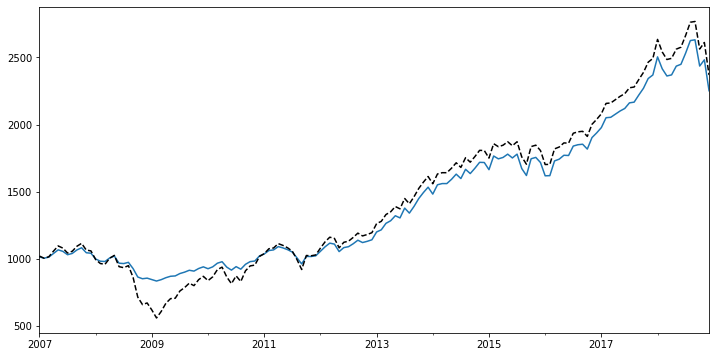

In [53]:
btr = run_cppi(tmi_return['2007':])
ax = btr['Wealth'].plot(figsize=(12,6), legend=False)
btr['Risky Wealth'].plot(ax=ax, style='k--', legend=False)

In [54]:
summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.073411,0.150463,-0.734939,4.523488,0.071592,0.096315,0.280618,-0.499943


In [55]:
summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
R,0.069416,0.100381,-0.588292,3.740932,0.045678,0.062953,0.382052,-0.229683


## Drawdown Constraints

In [56]:
btr = run_cppi(ind_return['2007':][['Steel', 'Fin', 'Beer']], drawdown=0.25)

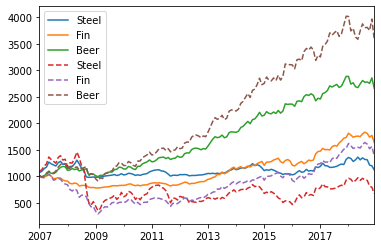

In [57]:
ax = btr['Wealth'].plot()
btr['Risky Wealth'].plot(ax=ax, style='--')

In [58]:
summary_stats(btr['Risky Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,-0.039660,0.306407,-0.459951,4.782828,0.152288,0.203837,-0.221642,-0.758017
Fin,0.027364,0.212204,-0.695200,4.621401,0.105744,0.149862,-0.012370,-0.718465
Beer,0.111554,0.127971,-0.670797,4.650878,0.056497,0.077388,0.620132,-0.271368


In [59]:
summary_stats(btr['Wealth'].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Steel,0.003784,0.097073,-0.441089,5.220481,0.047371,0.066991,-0.262958,-0.248059
Fin,0.041975,0.085028,-0.355163,4.153860,0.038342,0.054111,0.136964,-0.243626
Beer,0.084375,0.086263,-0.744111,4.571533,0.037937,0.051189,0.613413,-0.161186


We see significant improvements in risk metrics like maximum drawdown, VaR, and volatility. Meanwhile, Sharpe Ratios have improved.